In [1]:
cd ATML-PA-2/DAN/

/kaggle/working/ATML-PA-2/DAN


In [87]:
import importlib
import torch
import utils
import architecture
import train
import types
importlib.reload(utils)
importlib.reload(architecture)
importlib.reload(train)


from utils.dataset import FeatureTensorDataset, OfficeHomeDataset, _truncate_resnet_from
from torchvision.models import ResNet50_Weights
from importlib import reload
import train
from train import train_workflow
import types
from utils.tsne import tsne_plot, get_features
import matplotlib.pyplot as plt
import os
from architecture import resnet_classifier

In [7]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")

In [79]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [88]:
import torch
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score
)
import seaborn as sns

def evaluate_ds(ds, model, device, domain_name=None, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    loader = torch.utils.data.DataLoader(ds, shuffle=False, batch_size=32)

    with torch.inference_mode():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            logits = model(X)  
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(Y.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()



    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)

    if domain_name:
        print(f"\n=== Evaluation for {domain_name} Domain ===")
    print(f"Accuracy: {acc*100:.2f}%")
    print("Confusion Matrix:\n")
    sns.heatmap(cm, cmap="Blues")
    plt.show()
    print("Classification Report:\n", report)

    return {
        'domain': domain_name,
        'accuracy': acc,
        'confusion_matrix': cm,
        'classification_report': report,
        'y_true': y_true,
        'y_pred': y_pred
    }


In [89]:
import matplotlib.pyplot as plt

def analysis(source, target, config, cache_source=None, cache_target=None):
    
    model = resnet_classifier(num_classes=len(classes))

    if cache_source is None:
        source_ds = OfficeHomeDataset(root_dir, csv_file, source, transform)
        cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=64)

    if cache_target is None:
        target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)
        cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=64)

    truncated_model = _truncate_resnet_from(model, 'layer3')

    def _forward_impl(self, x):
        f4 = self.layer4(x)
        x = torch.flatten(self.avgpool(f4), 1)
        x = self.fc(x)
        return x, [x, f4]

    truncated_model.forward = types.MethodType(_forward_impl, truncated_model)

    cache_source_train, cache_source_test = torch.utils.data.random_split(cache_source, [0.8,0.2])
    torch.manual_seed(100)
    cache_target_train, cache_target_test = torch.utils.data.random_split(cache_target, [0.8,0.2])

    
    train_workflow(truncated_model, cache_source_train, cache_target_train, cache_target_test, config, device)

    def _forward_impl_2(self, x):
        f4 = self.layer4(x)
        x = torch.flatten(self.avgpool(f4), 1)
        x = self.fc(x)
        return x
    truncated_model.forward = types.MethodType(_forward_impl_2, truncated_model)
    
    print(device)
    print("Evaluating on target domain test set")
    evaluate_ds(cache_target_test, truncated_model, device, target[0])

    print("Evaluating on source domain test set")
    evaluate_ds(cache_target_test, truncated_model, device, source)

    print("Evaluating on source domain train set")
    evaluate_ds(cache_source_train, truncated_model, device, source)

    latents_s, _ = get_features(truncated_model[:-1], cache_source_test, batchsize=32, device=device)
    latents_t, _ = get_features(truncated_model[:-1], cache_target_test, batchsize=32, device=device)

    if latents_s.dim() > 2:
        latents_s = latents_s.flatten(start_dim=1)
    if latents_t.dim() > 2:
        latents_t = latents_t.flatten(start_dim=1)

    latents = torch.cat([latents_s, latents_t], dim=0)
    domain_labels = torch.cat([
        torch.zeros(latents_s.shape[0], dtype=torch.long),   # 0 = source
        torch.ones(latents_t.shape[0], dtype=torch.long)     # 1 = target
    ])

    fig, ax = plt.subplots(figsize=(8, 6))
    tsne_plot(latents, domain_labels, classes=["Source", "Target"], ax=ax, fig=fig, perplexity=30)
    plt.title("t-SNE Domain Clustering: Source vs Target")
    plt.show()

In [81]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]
source_ds = OfficeHomeDataset(root_dir, csv_file, sources, transform)
target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)

In [40]:
model = resnet_classifier(num_classes=len(classes))

In [10]:
cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=32)
cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=32)

Precomputing up to layer3: 100%|██████████| 69/69 [00:55<00:00,  1.24it/s]


Training:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20

Train loss: 1.59740 | Supervised: 1.59383 | MK-MMD: 0.00356 | Source train acc: 8.53% | Target test acc=22.34%



Training:   5%|▌         | 1/20 [00:10<03:16, 10.36s/it]


Epoch 2/20

Train loss: 0.65378 | Supervised: 0.65377 | MK-MMD: 0.00001 | Source train acc: 20.57% | Target test acc=28.06%



Training:  10%|█         | 2/20 [00:20<03:06, 10.39s/it]


Epoch 3/20

Train loss: 0.44100 | Supervised: 0.44098 | MK-MMD: 0.00002 | Source train acc: 26.29% | Target test acc=30.47%



Training:  15%|█▌        | 3/20 [00:30<02:53, 10.23s/it]


Epoch 4/20

Train loss: 0.33885 | Supervised: 0.33885 | MK-MMD: 0.00000 | Source train acc: 28.99% | Target test acc=33.68%



Training:  20%|██        | 4/20 [00:40<02:42, 10.17s/it]


Epoch 5/20

Train loss: 0.29608 | Supervised: 0.29606 | MK-MMD: 0.00002 | Source train acc: 30.40% | Target test acc=31.04%



Training:  25%|██▌       | 5/20 [00:50<02:31, 10.07s/it]


Epoch 6/20

Train loss: 0.22917 | Supervised: 0.22917 | MK-MMD: 0.00000 | Source train acc: 32.33% | Target test acc=33.56%



Training:  30%|███       | 6/20 [01:00<02:21, 10.09s/it]


Epoch 7/20

Train loss: 0.19210 | Supervised: 0.19210 | MK-MMD: 0.00000 | Source train acc: 33.22% | Target test acc=32.76%



Training:  35%|███▌      | 7/20 [01:11<02:11, 10.14s/it]


Epoch 8/20

Train loss: 0.16384 | Supervised: 0.16384 | MK-MMD: 0.00000 | Source train acc: 34.03% | Target test acc=35.51%



Training:  40%|████      | 8/20 [01:21<02:01, 10.12s/it]


Epoch 9/20

Train loss: 0.14623 | Supervised: 0.14623 | MK-MMD: 0.00000 | Source train acc: 34.63% | Target test acc=37.80%



Training:  45%|████▌     | 9/20 [01:31<01:50, 10.08s/it]


Epoch 10/20

Train loss: 0.11392 | Supervised: 0.11392 | MK-MMD: 0.00000 | Source train acc: 35.63% | Target test acc=35.17%



Training:  50%|█████     | 10/20 [01:41<01:40, 10.02s/it]


Epoch 11/20

Train loss: 0.10005 | Supervised: 0.10005 | MK-MMD: 0.00000 | Source train acc: 35.95% | Target test acc=38.49%



Training:  55%|█████▌    | 11/20 [01:51<01:29,  9.99s/it]


Epoch 12/20

Train loss: 0.07785 | Supervised: 0.07785 | MK-MMD: 0.00000 | Source train acc: 36.66% | Target test acc=41.12%



Training:  60%|██████    | 12/20 [02:01<01:20, 10.02s/it]


Epoch 13/20

Train loss: 0.07140 | Supervised: 0.07140 | MK-MMD: 0.00000 | Source train acc: 36.80% | Target test acc=34.71%



Training:  65%|██████▌   | 13/20 [02:11<01:10, 10.04s/it]


Epoch 14/20

Train loss: 0.06139 | Supervised: 0.06124 | MK-MMD: 0.00015 | Source train acc: 36.93% | Target test acc=35.97%



Training:  70%|███████   | 14/20 [02:21<01:00, 10.10s/it]


Epoch 15/20

Train loss: 0.04822 | Supervised: 0.04822 | MK-MMD: 0.00000 | Source train acc: 37.44% | Target test acc=35.28%



Training:  75%|███████▌  | 15/20 [02:31<00:50, 10.09s/it]


Epoch 16/20

Train loss: 0.04830 | Supervised: 0.04830 | MK-MMD: 0.00000 | Source train acc: 37.51% | Target test acc=37.92%



Training:  80%|████████  | 16/20 [02:41<00:40, 10.17s/it]


Epoch 17/20

Train loss: 0.04315 | Supervised: 0.04315 | MK-MMD: 0.00000 | Source train acc: 37.58% | Target test acc=38.83%



Training:  85%|████████▌ | 17/20 [02:51<00:30, 10.12s/it]


Epoch 18/20

Train loss: 0.03561 | Supervised: 0.03423 | MK-MMD: 0.00138 | Source train acc: 38.00% | Target test acc=32.88%



Training:  90%|█████████ | 18/20 [03:01<00:20, 10.07s/it]


Epoch 19/20

Train loss: 0.03017 | Supervised: 0.03017 | MK-MMD: 0.00000 | Source train acc: 37.98% | Target test acc=36.31%



Training:  95%|█████████▌| 19/20 [03:11<00:10, 10.03s/it]


Epoch 20/20

Train loss: 0.02574 | Supervised: 0.02574 | MK-MMD: 0.00000 | Source train acc: 38.16% | Target test acc=38.26%



Training: 100%|██████████| 20/20 [03:21<00:00, 10.08s/it]

cuda
Evaluating on target domain test set



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== Evaluation for Clipart Domain ===
Accuracy: 38.26%
Confusion Matrix:



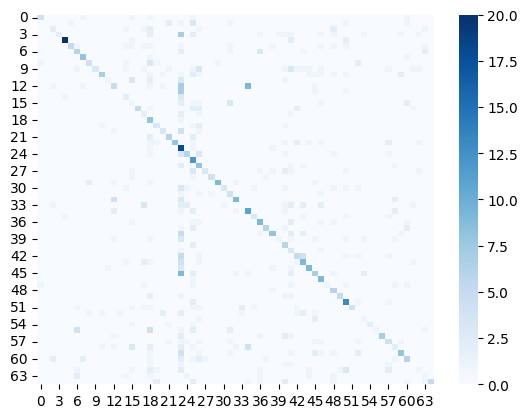

Classification Report:
               precision    recall  f1-score   support

           0     0.6667    0.4444    0.5333         9
           1     0.0000    0.0000    0.0000        10
           2     0.3333    0.2000    0.2500        10
           3     1.0000    0.0909    0.1667        22
           4     0.9091    0.8000    0.8511        25
           5     0.8333    0.2941    0.4348        17
           6     0.3750    0.4000    0.3871        15
           7     0.6667    0.8000    0.7273        10
           8     0.5714    0.3077    0.4000        13
           9     1.0000    0.1364    0.2400        22
          10     0.7000    0.3500    0.4667        20
          11     0.5000    0.1000    0.1667        10
          12     0.3125    0.1923    0.2381        26
          13     0.0000    0.0000    0.0000         9
          14     0.2222    0.3333    0.2667         6
          15     0.0625    0.0909    0.0741        11
          16     1.0000    0.3846    0.5556        13
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== Evaluation for ['Art', 'Real World', 'Product'] Domain ===
Accuracy: 38.26%
Confusion Matrix:



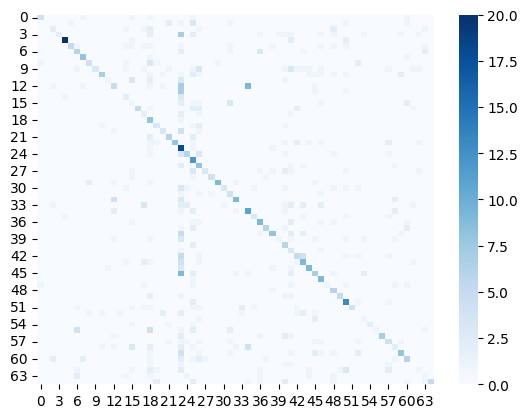

Classification Report:
               precision    recall  f1-score   support

           0     0.6667    0.4444    0.5333         9
           1     0.0000    0.0000    0.0000        10
           2     0.3333    0.2000    0.2500        10
           3     1.0000    0.0909    0.1667        22
           4     0.9091    0.8000    0.8511        25
           5     0.8333    0.2941    0.4348        17
           6     0.3750    0.4000    0.3871        15
           7     0.6667    0.8000    0.7273        10
           8     0.5714    0.3077    0.4000        13
           9     1.0000    0.1364    0.2400        22
          10     0.7000    0.3500    0.4667        20
          11     0.5000    0.1000    0.1667        10
          12     0.3125    0.1923    0.2381        26
          13     0.0000    0.0000    0.0000         9
          14     0.2222    0.3333    0.2667         6
          15     0.0625    0.0909    0.0741        11
          16     1.0000    0.3846    0.5556        13
   

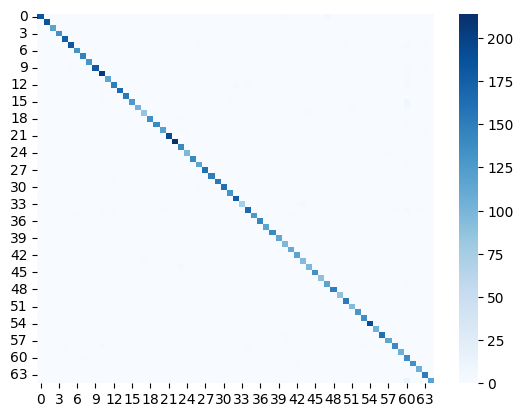

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9632    0.9812       190
           1     1.0000    1.0000    1.0000       185
           2     1.0000    0.9916    0.9958       119
           3     1.0000    1.0000    1.0000       133
           4     0.9943    1.0000    0.9971       174
           5     0.9891    0.9577    0.9731       189
           6     0.9925    1.0000    0.9962       132
           7     0.9932    0.9932    0.9932       148
           8     0.9924    1.0000    0.9962       130
           9     1.0000    0.9783    0.9890       184
          10     0.9581    0.9856    0.9717       209
          11     1.0000    0.9915    0.9957       117
          12     0.9803    0.9255    0.9521       161
          13     1.0000    0.9940    0.9970       166
          14     1.0000    1.0000    1.0000       154
          15     1.0000    0.9203    0.9585       138
          16     1.0000    0.9450    0.9717       109
   

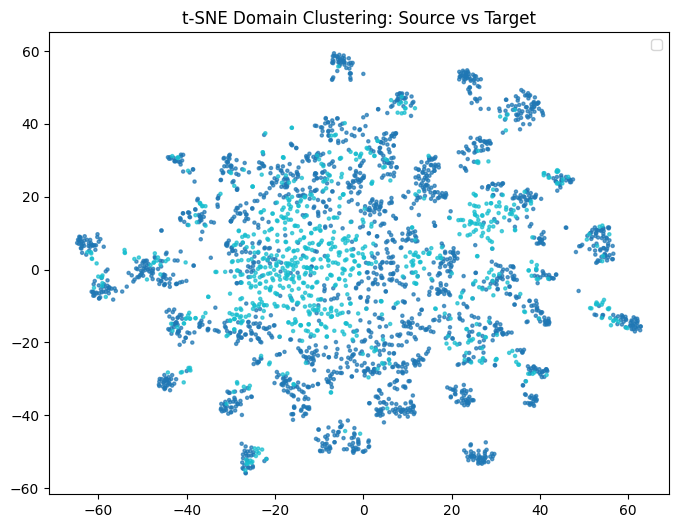

In [90]:
config = {'epochs': 20, 
          'lr':1e-2, 
          'batch_size':32, 
          'weight_decay':1e-3, 
          'sigmas':[2e-16,2e-12,2e-8,2e-4,2e+0,2e+4,2e+8,2e+12,2e+16], 
          'scale':16.0
          }
analysis(source=["Art", "Real World", "Product"], target=["Clipart"], config=config, cache_source=cache_source, cache_target=cache_target)

NameError: name 'cache_source_train' is not defined